<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/lm_generation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import sys
# if 'google.colab' in sys.modules:
#     !pip install -Uqq fastai einops datasets

In [2]:
import sys
import six

from fastai.text.all import *
# import datasets
# from datasets import load_dataset

In [3]:
sys.path.append("..")
from basic_tokenizers import ByteTextTokenizer
from basic_transformer import TransformerLM

## Experiment Tracking

Make sure you have wandb and are logged in:

In [4]:
# !pip install -Uqq wandb
# !wandb login

Load Experiment Tracking with Weights & Biases:

## Wandb experiment logging
Suggeted [wandb.init logging](https://docs.wandb.com/library/init) to help keep track of experiments:

**WANDB_NAME**

A specific name for a particular experiment, e.g. "lsh_2_hash_enwik8"

**GROUP**

Group identifiers will help organise and **group experiments together** in the wandb interface. Suggested identifier to use are:

- "TEST" : for general testing
- "SHARED-QK" : for Shared Query-Key experiments
- "LSH" : LSH-related experiemnts
- "REVERSIBLE" : reversible layers experiments
- "WMT" : for the WMT task

**NOTES**

A longer description of the run, like a -m commit message in git. This helps you remember what you were doing when you ran this run.

**CONFIG**

A dictionary-like object for saving inputs to your job, like hyperparameters for a model or settings for a data preprocessing job. The config will show up in a table in the UI that you can use to group, filter, and sort runs. Keys should not have . in the names, and values should be under 10 MB.

**TAGS**

A list of strings, which will populate the list of tags on this run in the UI. Tags are useful for organizing runs together, or applying temporary labels like "baseline" or "production". It's easy to add and remove tags in the UI, or filter down to just runs with a specific tag.

In [5]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing the encoder LM model works'
CONFIG = {}
TAGS =['enc_lm','test']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [6]:
# wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
#            name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [7]:
#!wget -P data/ http://mattmahoney.net/dc/enwik8.zip
#!unzip data/enwik8.zip -d data/
#!ls data
#!head -n 132 data/enwik8

In [8]:
def read_lines(path):
    """Tokenizes a text file."""
    assert os.path.exists(path)
    lines=[]
    with open(path, 'r') as f:
        tokens = 0
        for line in f:
            lines.append(line)  # + ['<eos>'])            
    return lines

In [9]:
enwik8 = read_lines('../data/enwik8')
df = pd.DataFrame({'text':enwik8})
print(len(df))
df.head()

1128024


,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


# Prepare Data

Load tokenizer

In [10]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [11]:
# # Patch the LMDataloader
# @patch
# def create_item(self:LMDataLoader, seq):
#     if seq>=self.n: raise IndexError
#     sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
#     st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
#     txt = self.chunks[st : st+sl+1]    
#     return LMTensorText(txt[:-1]),txt[1:]
#     # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

Calc splits

In [12]:
# Split enwik8 by character count
df['lens'] = df['text'].str.len()
df['lens_cum_sum'] = df.lens.cumsum()

train_cutoff = df.lens.sum() - 10000000  # keep all but 10M characters for val and test
    
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

Get dls

In [13]:
# Quick naive split alternative
# cut = int(len(df)*0.8)
# splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("text"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)
dls.show_batch(max_n=2)

,text,text_
0,<bos>Accidental electric heating can also be dangerous. An overloaded power cable is a frequent cause of fire. A battery as small as,Accidental electric heating can also be dangerous. An overloaded power cable is a frequent cause of fire. A battery as small as
1,<comment>rv anon v and changes</comment>\n<eos><bos> <id>62</id>\n<eos><bos>When blackjack was first introduced in the United States i,<comment>rv anon v and changes</comment>\n<eos><bos> <id>62</id>\n<eos><bos>When blackjack was first introduced in the United States it


In [14]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [15]:
vocab_sz = bte.vocab_size

# Begin Experiment Training

In [18]:
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

In [19]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(), cbs=[WandbCallback(log_model=False)],
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

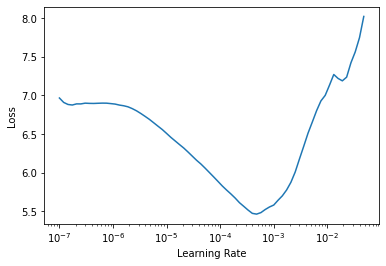

In [17]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(2, 5e-4, wd=0.05)  # cbs=WandbCallback(log_model=False)

epoch     train_loss  valid_loss  accuracy  perplexity  time    


TypeError: 'function' object is not subscriptable

In [26]:
%debug

> /home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/fastai/callback/wandb.py(169)<listcomp>()
    167 def _format_config_value(v):
    168     if isinstance(v, list):
--> 169         return [_format_config_value[item] for item in v]
    170     elif hasattr(v, '__stored_args__'):
    171         return {**_format_config(v.__stored_args__), '_name': v}



ipdb>  _format_config_value


<function _format_config_value at 0x7f14cd05ee60>


ipdb>  v


*** NameError: name 'v' is not defined


ipdb>  item


<function accuracy at 0x7f14e04d20e0>


ipdb>  u


> /home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/fastai/callback/wandb.py(169)_format_config_value()
    167 def _format_config_value(v):
    168     if isinstance(v, list):
--> 169         return [_format_config_value[item] for item in v]
    170     elif hasattr(v, '__stored_args__'):
    171         return {**_format_config(v.__stored_args__), '_name': v}



ipdb>  v


[<function accuracy at 0x7f14e04d20e0>, <fastai.metrics.Perplexity object at 0x7f147ef1b7d0>]


ipdb>  q
